## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [1]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
import seaborn as sn
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [2]:
def regression_logistique(X,t,Nitermax,eps_conv):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))
    w_old = w 
    y = 1/2*np.ones((N_train,)) #initialisation de la prédiction à 0,5 pour chaque donnée
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

    # boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) and (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))
        R = np.diag(y*(1-y))
        for i in range (len(R)):
            if R[i,i]==0:
                R[i,i]=10**-10
        w_old = w 
        try :
            z = X.dot(w_old)-la.inv(R).dot(y-t) 
            w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
        except :
            z = X.dot(w_old)-la.pinv(R).dot(y-t)
            w = la.pinv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
        
         
    return w, Niter


### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [3]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train_1 = synth_train[:,1:]
N_train = np.size(x_train_1,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test_1 = synth_test[:,1:]
N_test = np.size(x_test_1,axis=0)

In [4]:
print(synth_train[0:10])

[[ 2.         -0.72221141  2.00447087]
 [ 2.         -0.92467912  0.48366928]
 [ 2.         -0.76602281  0.79432891]
 [ 2.         -0.07328948  0.96992915]
 [ 1.         -1.39291198  0.99969709]
 [ 2.         -0.20223339  1.35033191]
 [ 2.          0.48173767  0.98441858]
 [ 1.         -1.86551212  1.54773159]
 [ 2.         -0.15246873  0.92248969]
 [ 2.          0.38635649  0.36633672]]


In [5]:
print('Minimum of feature x : ', min(np.min(synth_train[:,1]), np.min(synth_test[:1])), ', maximum of feature x : ', max(np.max(synth_train[:,1]), np.max(synth_test[:,1])))
print('Minimum of feature y : ', min(np.min(synth_train[:,2]), np.min(synth_test[:2])), ', maximum of feature y : ', max(np.max(synth_train[:,2]), np.max(synth_test[:,2])))

Minimum of feature x :  -2.30408372892482 , maximum of feature x :  1.41253669598274
Minimum of feature y :  -0.516182355090629 , maximum of feature y :  3.87335148713437


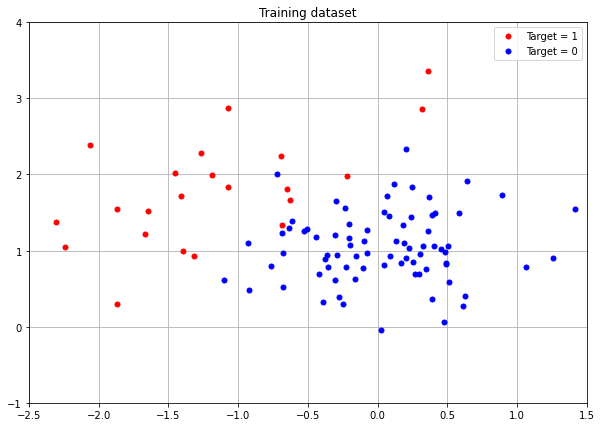

In [6]:
train_1 = synth_train[synth_train[:,0] == 1]
train_2 = synth_train[synth_train[:,0] == 2]
X_train_1, Y_train_1 = train_1[:,1], train_1[:,2]
X_train_2, Y_train_2 = train_2[:,1], train_2[:,2]
plt.figure(figsize=(10, 7))
plt.xlim(-2.5,1.5)
plt.ylim(-1,4)
plt.plot (X_train_1,Y_train_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_train_2,Y_train_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0')
plt.legend()
plt.title("Training dataset")
plt.grid()
plt.show()

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [7]:
X = np.hstack((np.ones((N_train,1)),x_train_1))
t = 2-class_train   # 0 if class=2, 1 if class=1
t = t.astype(int)

X_test = np.hstack((np.ones((N_test,1)),x_test_1))
t_test = 2-class_test   # 0 if class=2, 1 if class=1
t_test = t_test.astype(int)

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


#### Cross-validation

First of all, we use 10-fold cross-validation to evaluate the performance of our logistic regression model. We use the AUC score.

In [8]:
def sigma (x): 
    return 1/(1+np.exp(-x))

def cross_validation (X, t, n):
    d = np.insert(X,X.shape[1],t,axis=1)
    np.random.shuffle(d)
    scores = []
    size_test = len(d)//n
    for i in range(n):
        # extraction of testset
        testset  = d[i*size_test:(i+1)*size_test,:] 
        # extraction of trainset
        trainset = np.delete(d, [k for k in range (i*size_test,(i+1)*size_test)], axis=0)
        X_tr_cv = trainset[:,:trainset.shape[1]-1]
        X_te_cv = testset[:,:testset.shape[1]-1]
        t_tr_cv = trainset[:,trainset.shape[1]-1]
        t_te_cv = testset[:,testset.shape[1]-1]
        w, Niter = regression_logistique(X_tr_cv, t_tr_cv, 50, 1e-3)
        y_te_cv = sigma(X_te_cv.dot(w))
        seuil = 0.5
        prediction_te_cv = (y_te_cv>seuil)*1
        false_positive_rate, true_positive_rate, thresholds = roc_curve(t_te_cv,y_te_cv)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        if np.isnan(roc_auc) == False :
            scores.append(roc_auc)
    return scores

scores = cross_validation (X, t, 10)
print('AUC scores for each sample :', scores)
print('Average score :', round(np.mean(scores), 3))

AUC scores for each sample : [1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]
Average score : 0.981


C:\Users\remyd\anaconda3new\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


The cross validation shows that our model makes good predictions. Indeed, the average AUC score is very close to 1. 

#### Logistic regression on the dataset

In [9]:
#Question 1
w, Niter = regression_logistique(X, t, 50, 1e-3)

#Question 2
y = sigma(X.dot(w))
y_test = sigma(X_test.dot(w))
seuil = 0.5
prediction = (y>seuil)*1
prediction_test = (y_test>seuil)*1

#### Confusion matrix on the train set

In [10]:
data = {'y_Actual': t ,
        'y_Predicted': prediction
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
#sn.heatmap(confusion_matrix, annot=True)
#plt.show()

Predicted,0,1
Actual,,
0,77,1
1,2,20


We have 2 false negatives and 1 false positive. The error rate is 3%.

#### ROC curve and AUC score

Text(0.5, 0, 'False Positive Rate')

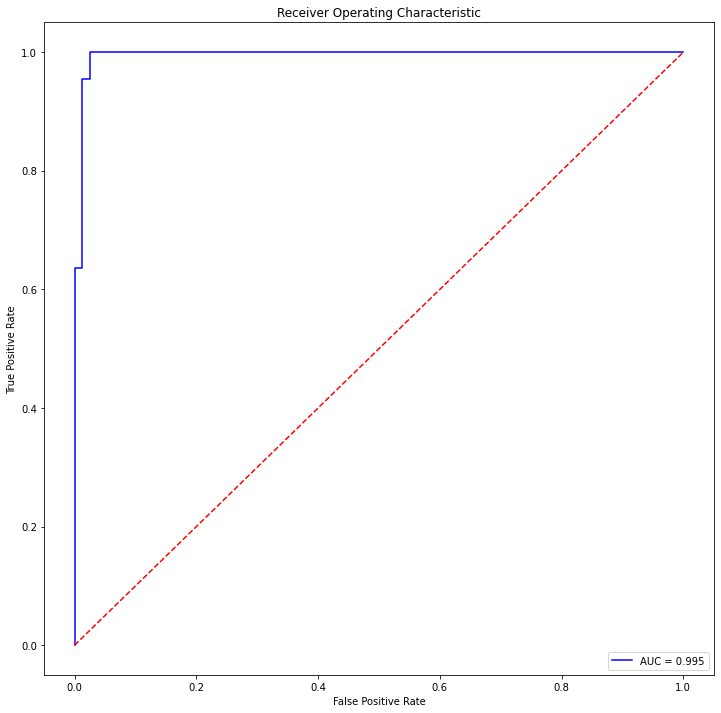

In [11]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(t,y)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We obtain a satisfying AUC, very close to 1. This AUC score is higher than the score we obtain with cross validation because we test the model on known data. Our model gives good estimations of probabilities, and for most of samples, a data in class 1 has a higher $y_n=\sigma(w^T x)$ than a data in class 0.

#### Areas of decision and boundary

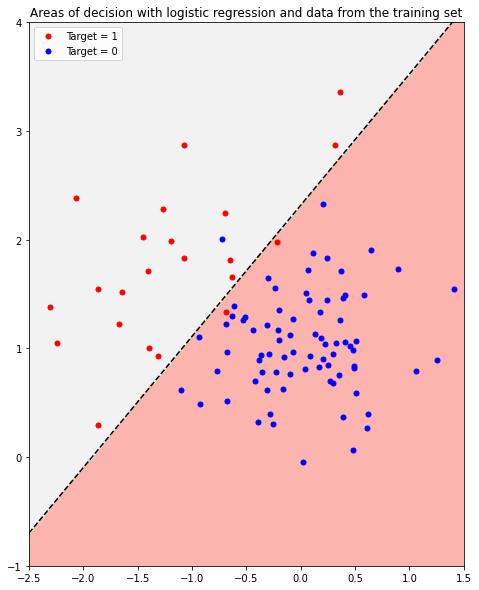

In [12]:
Nx1=200 # number of samples for display
Nx2=200
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-1,4,Nx2)  # sampling of the x2 axis
X1,X2=np.meshgrid(x1,x2)

class_reg_log = np.zeros((Nx1, Nx2))
for i in range (Nx1):
    for j in range(Nx2):
        class_reg_log[i][j]=(sigma(np.array([1, X1[i][j], X2[i,j]]).dot(w))>seuil)*1
        
plt.figure(figsize=(10, 10))
plt.plot (X_train_1,Y_train_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_train_2,Y_train_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0') 
boundary = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,boundary,'k--')
plt.imshow(class_reg_log, cmap=plt.cm.Pastel1, origin = 'lower', extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)))
plt.legend()
plt.title("Areas of decision with logistic regression and data from the training set")
plt.show()

The boundary is linear and very close to the boundary obtained with LDA in the previous lab.

#### Confusion matrix on the test set

In [13]:
data = {'y_Actual': t_test ,
        'y_Predicted': prediction_test
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
#sn.heatmap(confusion_matrix, annot=True)
#plt.show()

Predicted,0,1
Actual,,
0,136,2
1,10,52


In the training set, we have 22 points in the class 1 and 78 points in class 0. So the model knows better the class 0. As a consequence, we have more errors on the test set on points belonging to class 1 (10 errors, instead of 2 in class 0). The error rate is 6%. It is higher than the training set because the model is now tested on data it does not know.

#### ROC Curve on test set

Text(0.5, 0, 'False Positive Rate')

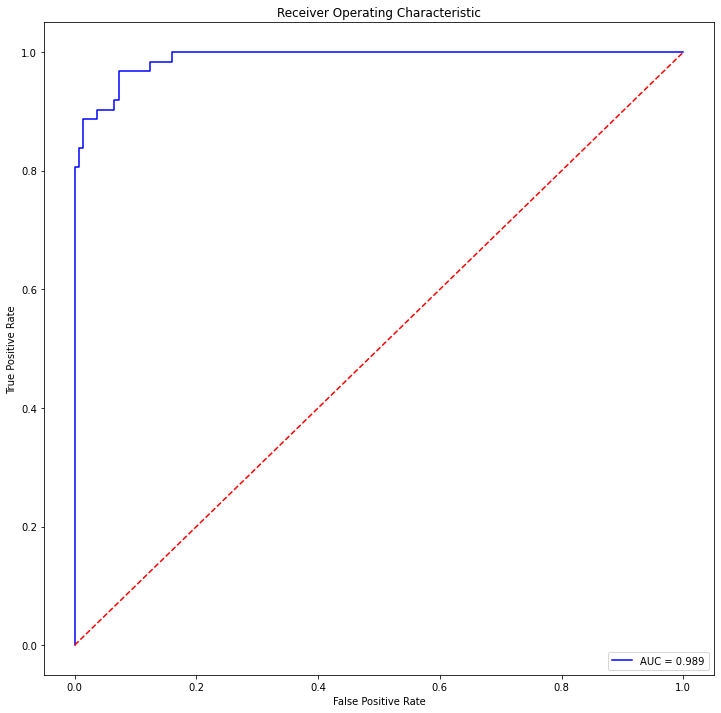

In [14]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(t_test,y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

AUC score on test set is lower than the score on the train set, but is very close to cross validation AUC score. The model generalizes well the data.

#### Areas of decision and samples from test set

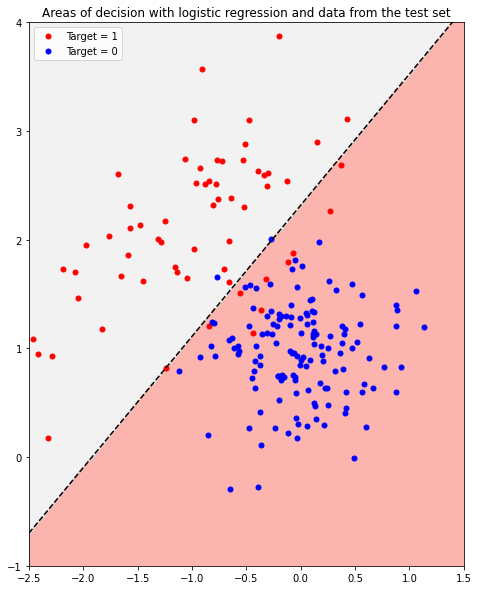

In [15]:
test_1 = synth_test[synth_test[:,0] == 1]
test_2 = synth_test[synth_test[:,0] == 2]
X_test_1, Y_test_1 = test_1[:,1], test_1[:,2]
X_test_2, Y_test_2 = test_2[:,1], test_2[:,2]

Nx1=200 # number of samples for display
Nx2=200
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-1,4,Nx2)  # sampling of the x2 axis
X1,X2=np.meshgrid(x1,x2)

class_reg_log = np.zeros((Nx1, Nx2))
for i in range (Nx1):
    for j in range(Nx2):
        class_reg_log[i][j]=(sigma(np.array([1, X1[i][j], X2[i,j]]).dot(w))>seuil)*1
        
plt.figure(figsize=(10, 10))
plt.plot (X_test_1,Y_test_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_test_2,Y_test_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0') 
boundary = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,boundary,'k--')
plt.imshow(class_reg_log, cmap=plt.cm.Pastel1, origin = 'lower', extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)))
plt.legend()
plt.title("Areas of decision with logistic regression and data from the test set")
plt.show()

#### Impact of outliers on the decision boundary

##### Creation of outliers

In [16]:
synth_train = np.loadtxt('synth_train.txt')
outliers = np.array([[1,-2.33,3.8],
                    [1, -2.33, 3.7],
                    [1, -2.4, 3.75],
                    [1, -2.3, 3.95],
                    [1, -2.25, 3.9],
                    [1, -2.45, 3.75],
                    [1, -2.45, 3.8],
                    [1, -2.35, 3.9],
                    [1, -2.45, 3.9],
                    [1, -2.4, 3.85],
                    [1, -2.25, 3.8]])
synth_train = np.concatenate((synth_train,outliers),axis= 0)
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

##### Visualisation of data

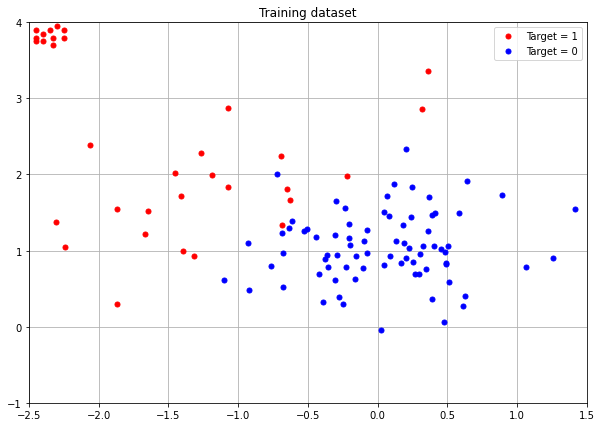

In [17]:
train_1 = synth_train[synth_train[:,0] == 1]
train_2 = synth_train[synth_train[:,0] == 2]
X_train_1, Y_train_1 = train_1[:,1], train_1[:,2]
X_train_2, Y_train_2 = train_2[:,1], train_2[:,2]
plt.figure(figsize=(10, 7))
plt.xlim(-2.5,1.5)
plt.ylim(-1,4)
plt.plot (X_train_1,Y_train_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_train_2,Y_train_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0')
plt.legend()
plt.title("Training dataset")
plt.grid()
plt.show()

##### New boundary and areas of decision

In [18]:
X_out = np.hstack((np.ones((N_train,1)),x_train))
t_out = 2-class_train   # 0 if class=2, 1 if class=1
t_out = t_out.astype(int)

w, Niter = regression_logistique(X_out, t_out, 50, 1e-3)

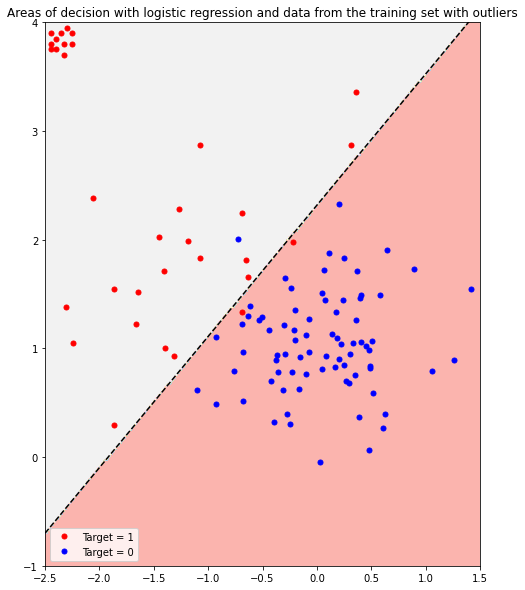

In [19]:
Nx1=200 # number of samples for display
Nx2=200
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-1,4,Nx2)  # sampling of the x2 axis
X1,X2=np.meshgrid(x1,x2)

class_reg_log = np.zeros((Nx1, Nx2))
for i in range (Nx1):
    for j in range(Nx2):
        class_reg_log[i][j]=(sigma(np.array([1, X1[i][j], X2[i,j]]).dot(w))>seuil)*1
        
plt.figure(figsize=(10, 10))
plt.plot (X_train_1,Y_train_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_train_2,Y_train_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0') 
boundary = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,boundary,'k--')
plt.imshow(class_reg_log, cmap=plt.cm.Pastel1, origin = 'lower', extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)))
plt.legend()
plt.title("Areas of decision with logistic regression and data from the training set with outliers")
plt.show()

With logistic regression, the boundary of decision does not move at all when we add data far from the boundary in the good area of decision. As a consequence, these new points does not affect the prediction of other points. Of course, if we add some points far from the boundary beloging to the opposite class, the boundary will be affected.

##### Comparison with LDA

In [20]:
Nx1=200 # number of samples for display
Nx2=200
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-1,4,Nx2)  # sampling of the x2 axis
X1,X2=np.meshgrid(x1,x2) 

N = len(synth_train)
N1 = len(train_1)
N2 = len(train_2)
pi_1 = N1/N
pi_2 = N2/N

mu_1 = np.zeros(2) 
mu_2 = np.zeros(2) 
     
mu_1[0]=np.sum(train_1[:,1])/N1
mu_1[1]=np.sum(train_1[:,2])/N1
mu_2[0]=np.sum(train_2[:,1])/N2
mu_2[1]=np.sum(train_2[:,2])/N2
 
sigma_1 = np.zeros((2,2))
sigma_2 = np.zeros((2,2))
for i in range (len(train_1)):
    sigma_1 += np.outer(train_1[i,1:]-mu_1, train_1[i,1:]-mu_1)
for i in range (len(train_2)):
    sigma_2 += np.outer(train_2[i,1:]-mu_2, train_2[i,1:]-mu_2)
    
sigma_1 = sigma_1/N1
sigma_2 = sigma_2/N2
sigma_LDA = (N1/N)*sigma_1 + (N2/N)*sigma_2

#LDA classifier
def y1_LDA(x):
    return (x.T)@np.linalg.inv(sigma_LDA)@mu_1-0.5*mu_1.T@np.linalg.inv(sigma_LDA)@mu_1+math.log(pi_1)

def y2_LDA(x):
    return (x.T)@np.linalg.inv(sigma_LDA)@mu_2-0.5*mu_2.T@np.linalg.inv(sigma_LDA)@mu_2+math.log(pi_2)

#function that gives the prediction on a data set "data"
def predire_LDA (data):
    pred = []
    for i in range(len(data)):
        if y1_LDA(data[i,1:])>y2_LDA(data[i,1:]):
            pred.append(1)
        else :
            pred.append(0)
    return (pred)

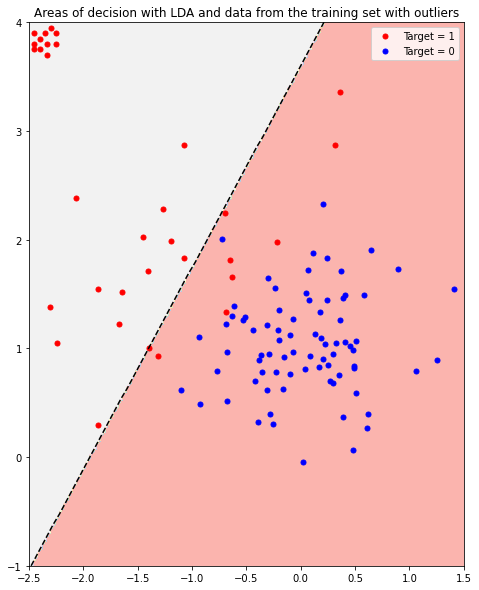

In [21]:
def prediction_LDA (x,y):
    if y1_LDA(np.array([x,y])) > y2_LDA(np.array([x,y])):
        return 1
    else :
        return 0

eps = 1.25*10e-3
frontiere_x1 = [] 
frontiere_x2 = [] 
class_LDA = np.zeros((Nx1, Nx2))
for i in range (Nx1):
    for j in range(Nx2):
        class_LDA[i][j]=prediction_LDA(X1[i][j], X2[i][j])
        if abs (y1_LDA(np.array([X1[i][j],X2[i][j]])) - y2_LDA(np.array([X1[i][j],X2[i][j]])))<eps:
            frontiere_x1.append(X1[i][j])
            frontiere_x2.append(X2[i][j])


plt.figure(figsize=(10, 10))
plt.plot (X_train_1,Y_train_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_train_2,Y_train_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0')
plt.plot (frontiere_x1, frontiere_x2, 'k--')
plt.imshow(class_LDA, cmap=plt.cm.Pastel1, origin = 'lower', extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)))
plt.legend()
plt.title("Areas of decision with LDA and data from the training set with outliers")
plt.show()

We notice that, with LDA, the boundary takes into account the new points. This method is sensitive to outliers, and it affects the prediction on the other points : some points from class 1 were well classified before adding the new points, and now they are considered as points from class 0.

##### Logistic regression and LDA boundaries

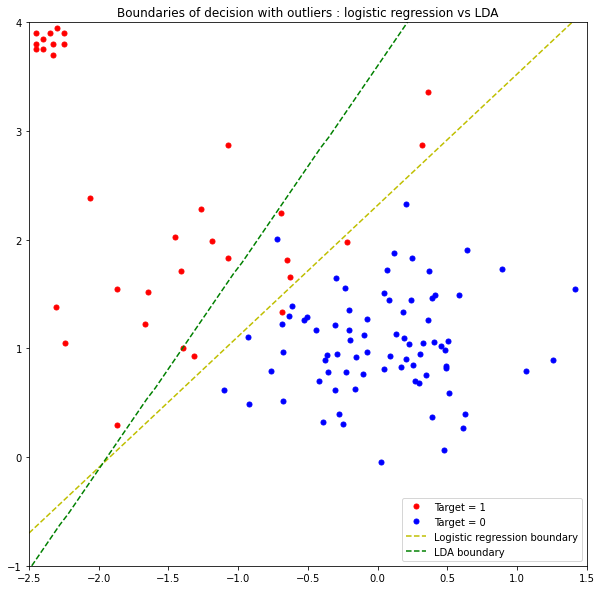

In [22]:
plt.figure(figsize=(10, 10))
plt.plot (X_train_1,Y_train_1, linestyle = 'none', marker = 'o', c = 'red', markersize = 5, label = 'Target = 1')
plt.plot (X_train_2,Y_train_2, linestyle = 'none', marker = 'o', c = 'blue', markersize = 5, label = 'Target = 0') 
boundary = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,boundary,'y--', label = 'Logistic regression boundary')
plt.plot (frontiere_x1, frontiere_x2, 'g--', label = 'LDA boundary')
plt.xlim([-2.5, 1.5])
plt.ylim([-1, 4])
plt.legend()
plt.title("Boundaries of decision with outliers : logistic regression vs LDA")
plt.show()

The advantage of logistic regression compared to LDA is its absence of sensitivity to outliers.

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [23]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


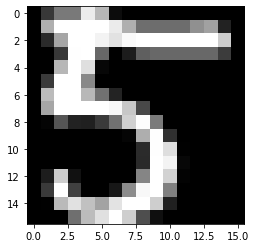

In [24]:
# Digit 5
n=9;
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

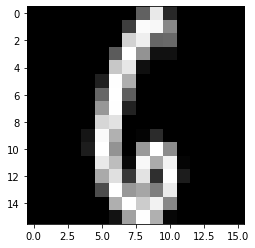

In [25]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [26]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((len(train_5[145:,:])+len(train_6[200:,:]),1))   # label 1 for digit 6
class_test[:len(train_5[145:,:])] = 0       # label 0 for digit 5

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


In [27]:
# Exercise 2

#Question 1
print ('max = ', np.max(I), ', min = ', np.min(I))

max =  1.0 , min =  -1.0


In [28]:
#Question 2
lis_sig = []
lis_non_sig = []
for i in range (len(x_train_brut.T)):
    if std(x_train_brut.T[i])>0.5:
        lis_sig.append(i)
    else : 
        lis_non_sig.append(i)
len(lis_sig)

173

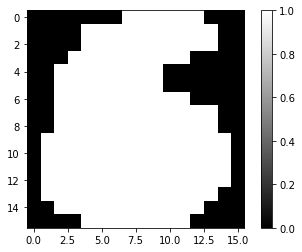

In [29]:
#Question 3

Isig = np.zeros(16*16)
Isig[lis_sig]=1

I = reshape(Isig,(16,16))

plt.imshow(I,cmap='gray', )
plt.colorbar()
plt.show()

The most significant pixels are logically situated in the middle of the picture. Indeed, the pixels on the edges do not bring information and are not useful to distinguish a 5 or a 6.

In [30]:
#Question 4 and 5
x_train = x_train_brut[:,lis_sig]
x_test = x_test_brut[:,lis_sig]

X_train = np.hstack((np.ones((N_train,1)),x_train))
X_test = np.hstack((np.ones((N_test,1)),x_test))

In [31]:
#Question 6
class_tr=class_train.reshape(1,-1)[0]
class_te=class_test.reshape(1,-1)[0]
class_tr = class_tr.astype(int)
class_te = class_te.astype(int)

##### Cross validation

In [32]:
scores = cross_validation (X_train, class_tr, 10)
print('AUC scores for each sample :', scores)
print('Average score :', round(np.mean(scores), 3))

<ipython-input-2-b32c4f4c2f97>:34: RuntimeWarning: overflow encountered in exp
  y = 1/(1+np.exp(-X.dot(w)))
<ipython-input-8-97865c400f19>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


AUC scores for each sample : [0.9963369963369964, 0.9583333333333333, 0.9708333333333333, 0.9821428571428571, 0.989010989010989, 0.9515570934256056, 0.9535714285714285, 0.989010989010989, 0.9719298245614035, 0.9267399267399268]
Average score : 0.969


With cross validation, we obtain an AUC score very close to 1. Now, we should evaluate the performance on the training set and the test set.

In [33]:
w, Niter = regression_logistique(X_train, class_tr, 13, 1e-3)
y_train = sigma(X_train.dot(w))
y_test = sigma(X_test.dot(w))
seuil = 0.5
prediction_train = (y_train>seuil)*1
prediction_test = (y_test>seuil)*1

[-9.98704984  1.12205279 -0.52734079  2.43357445 -1.15667169 -0.1219868
  0.22245698  1.72799263 -7.3894166   1.92756387 -3.52994513  0.58012907
 -3.65469818 -2.12430173 -3.18497467 -0.50988136 -0.75514155  1.46846025
 -1.9456921  -1.38667971  2.52417209  0.31838461 -3.07337983  5.56160245
 -4.79328322  5.41118408 -2.76630277 -5.28097692  1.20336692 -0.27270141
 -0.9865324  -6.34368573  4.46550455 -5.44544813  8.65707548 -9.40104204
 -2.93429823  0.09973828 -3.21832372 -3.02140365  0.99938188 -1.10483063
  2.65742731 -4.94289895  3.15525477  6.10645614  0.21803454  1.49948016
  5.23573986 -2.00546669 -5.88703758  2.06747172 -4.09382071  0.33511467
 -0.24055236 -1.55789622 -1.07972424  1.43784944 -2.46945598 -1.98690155
  5.83279707 -3.87316691  0.57059576  3.86984225  2.31605886  0.66037292
 -2.11226021 -0.70104291  0.09104848 -0.70845073  1.25397718  1.07584359
  0.95034253  0.21821243 -3.67133811 -4.01106529 -1.58960031 -2.19956899
  1.84291636  0.71620733 -0.64180428 -2.05523237  3.

#### Confusion matrix on the train set

In [34]:
data = {'y_Actual': class_tr ,
        'y_Predicted': prediction_train
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
#sn.heatmap(confusion_matrix, annot=True)
#plt.show()

Predicted,0,1
Actual,,
0,145,0
1,0,200


We do not have any error on the training set.

#### ROC curve

Text(0.5, 0, 'False Positive Rate')

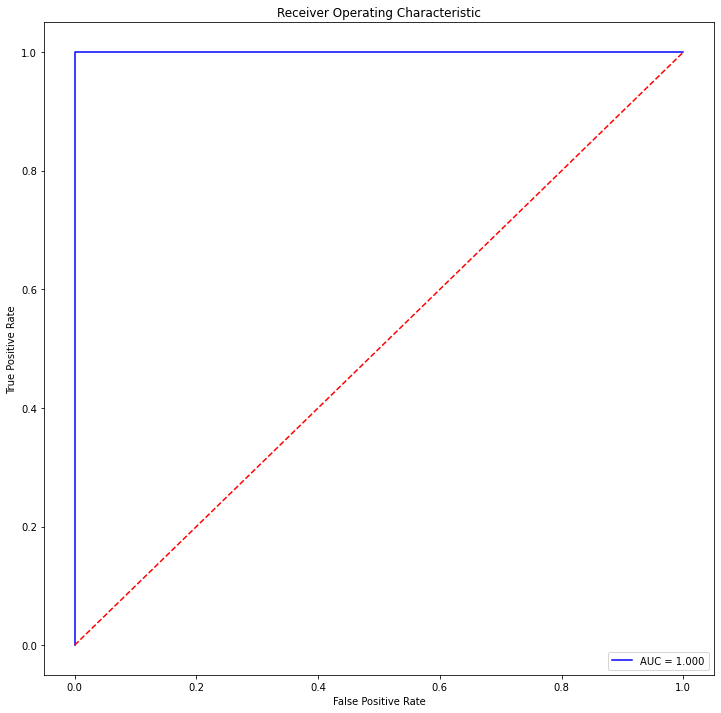

In [35]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(class_tr,y_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We have a perfect classification between class 1 and class 0. It means that the probability that the model ranks a random positive example more highly than a random negative example is 1.

#### Confusion matrix on the test set

In [36]:
data = {'y_Actual': class_te ,
        'y_Predicted': prediction_test
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
#sn.heatmap(confusion_matrix, annot=True)
#plt.show()

Predicted,0,1
Actual,,
0,366,45
1,24,440


#### ROC curve

Text(0.5, 0, 'False Positive Rate')

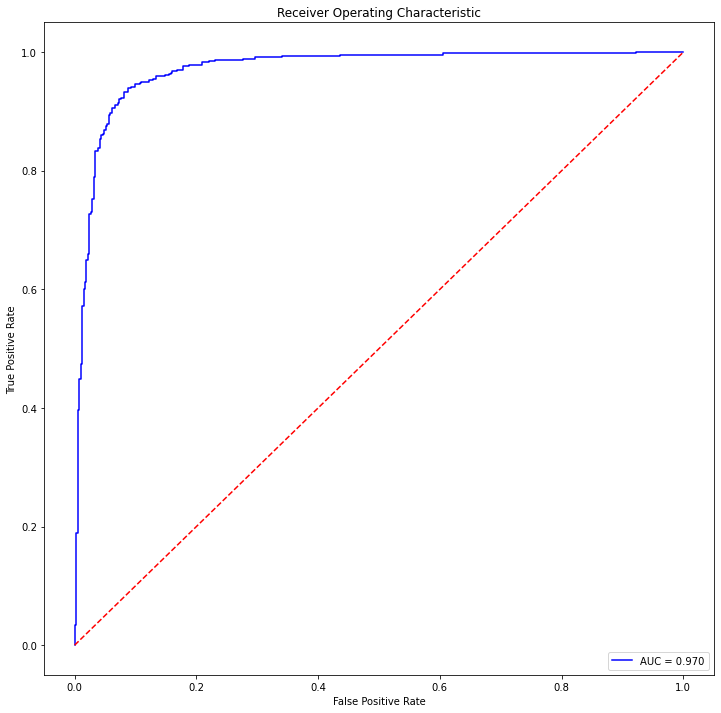

In [37]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(class_te,y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

The AUC score on the test set is very close to the score calculated with cross validation. This is a proof of the robustness of the model.

#### Error rate

In [38]:
erreur = sum(abs(class_te-prediction_test))/N_test
print ('Classification error rate :', "{:.2%}".format(erreur))

Classification error rate : 7.89%


#### Misclassified examples

In [39]:
#5 prédits comme des 6
indices_faux_positifs = np.where(prediction_test - class_te == 1 )[0]
#6 prédits comme des 5
indices_faux_négatifs = np.where(prediction_test - class_te == -1 )[0]

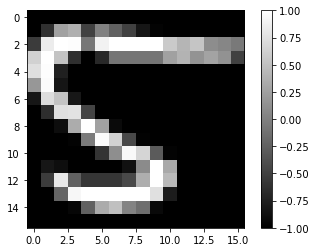

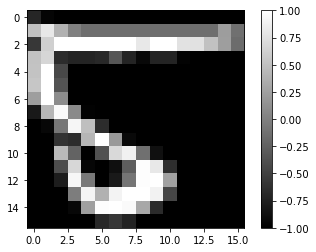

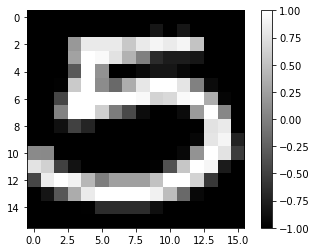

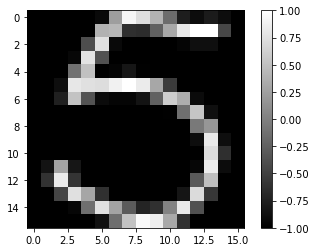

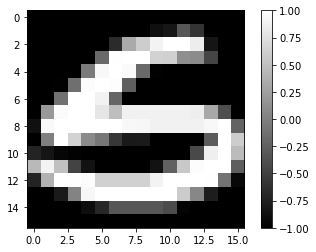

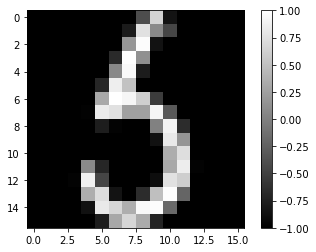

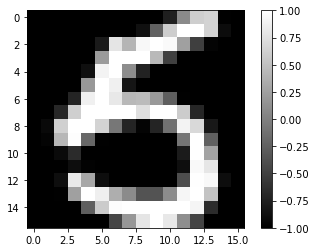

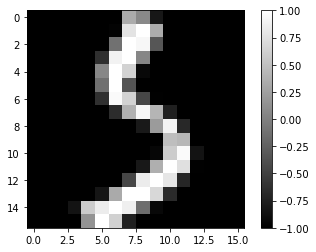

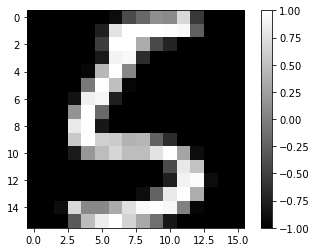

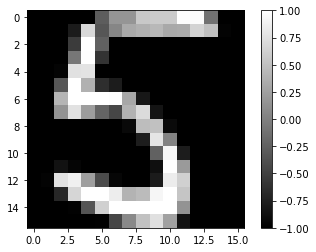

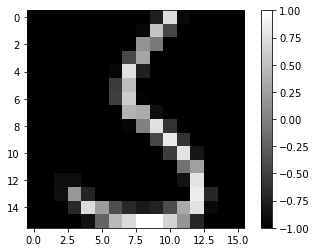

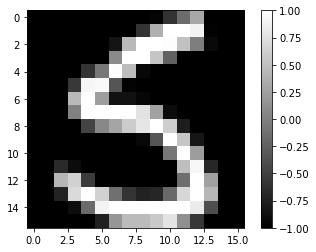

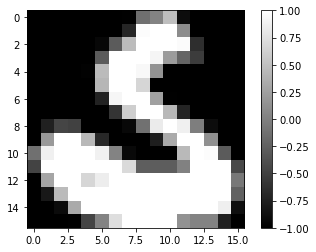

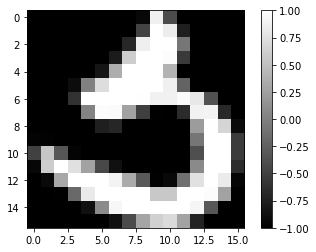

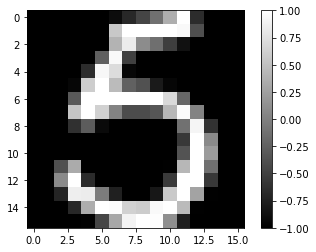

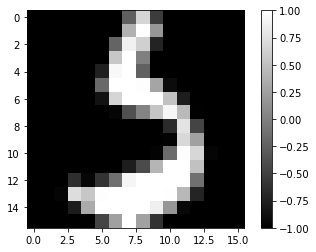

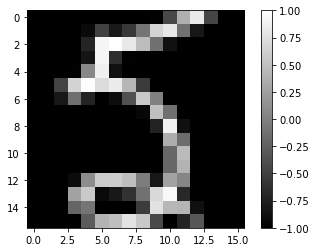

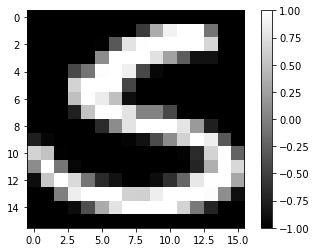

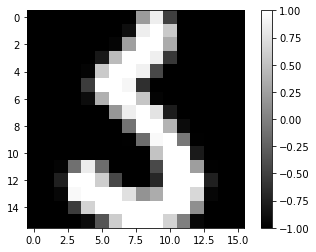

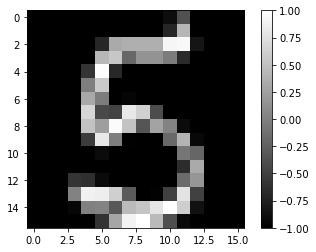

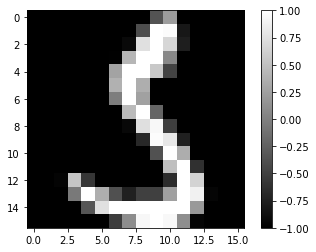

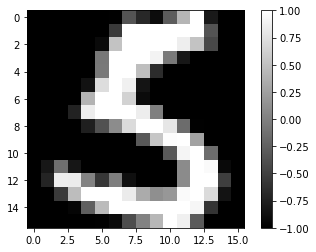

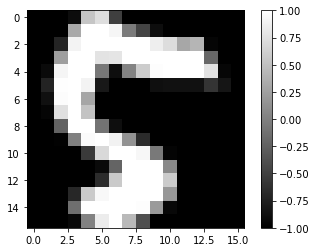

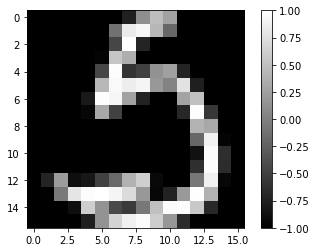

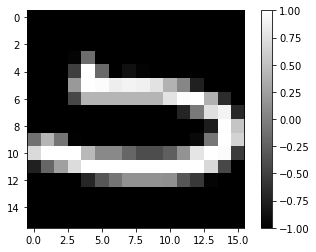

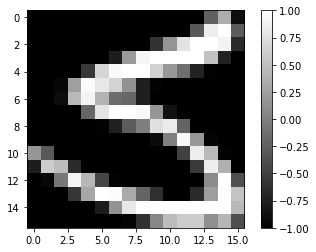

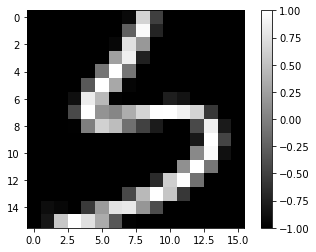

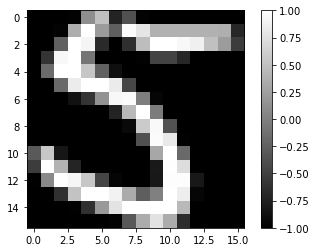

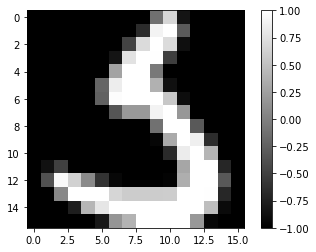

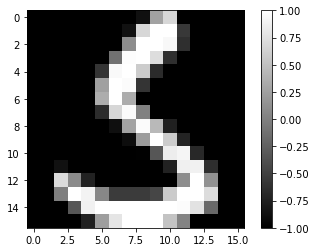

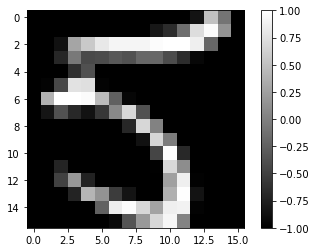

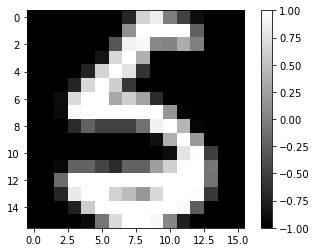

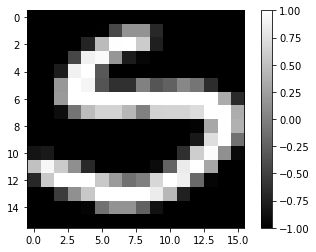

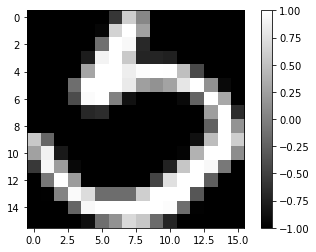

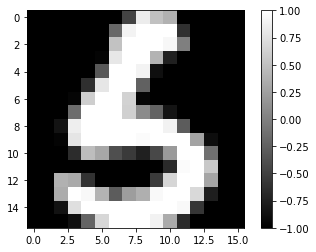

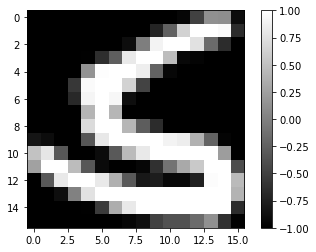

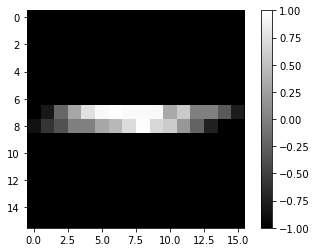

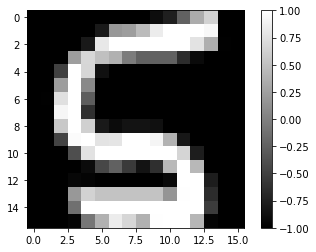

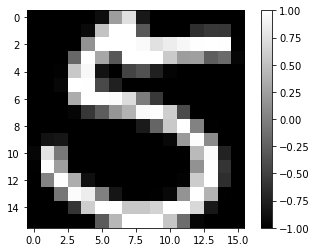

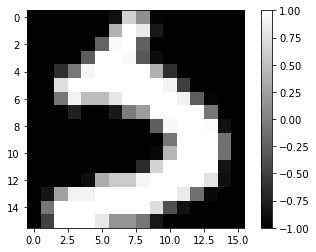

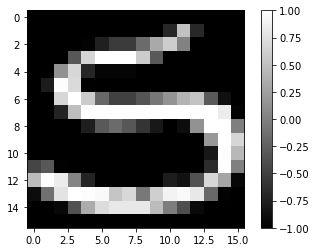

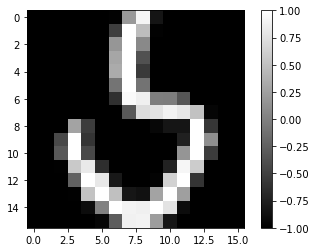

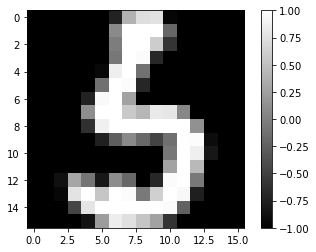

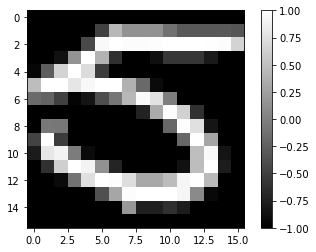

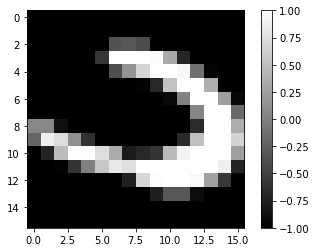

In [40]:
for i in indices_faux_positifs :
    I = np.reshape(x_test_brut[i],(16,16))
    plt.imshow(I,cmap='gray')
    plt.colorbar()
    plt.show()

Some "5" are predicted as a "6" because they have the shape of a 6 missing a piece of it. Some of them also have the shape of a "S".

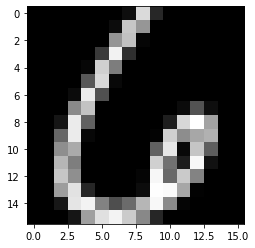

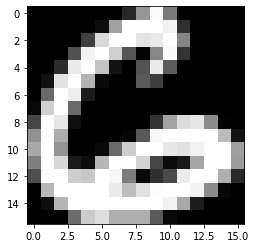

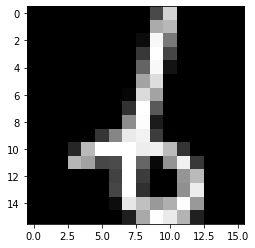

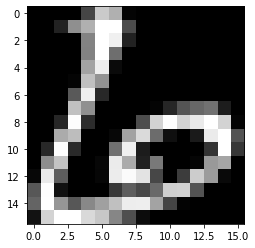

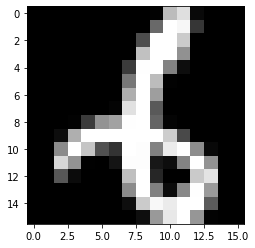

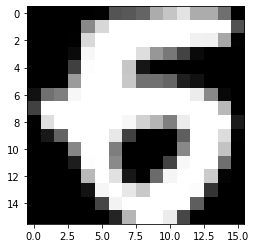

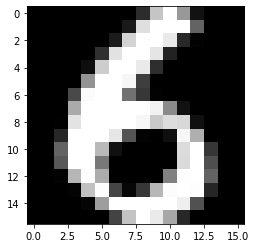

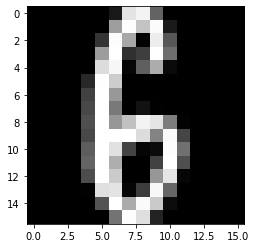

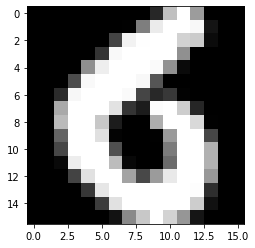

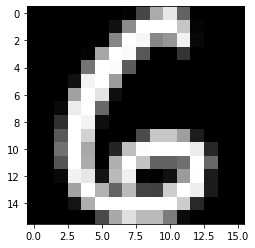

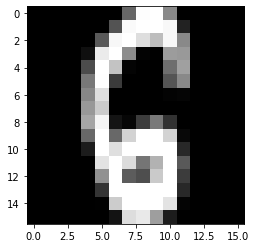

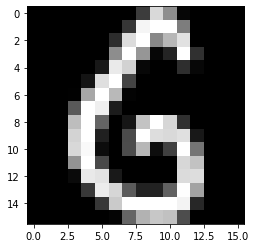

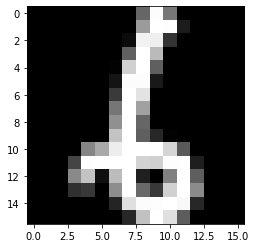

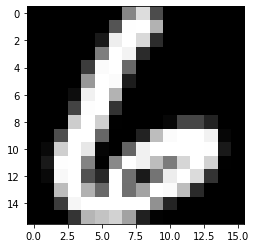

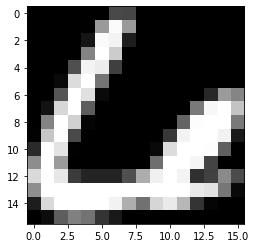

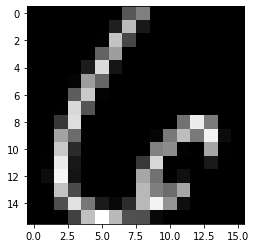

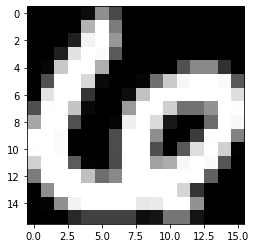

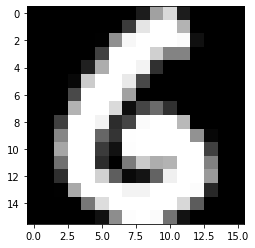

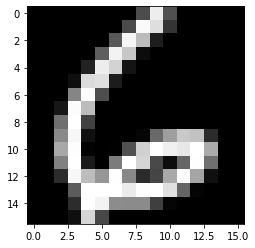

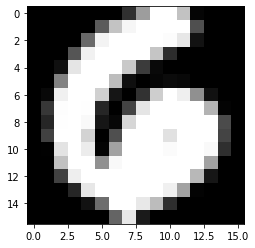

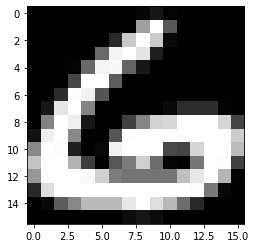

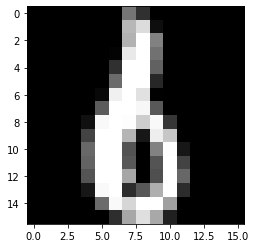

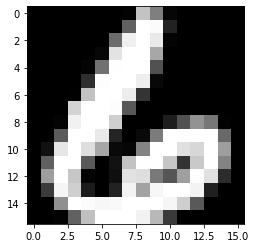

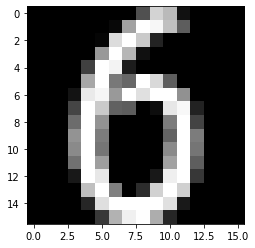

In [41]:
for i in indices_faux_négatifs :
    I = np.reshape(x_test_brut[i],(16,16))
    plt.imshow(I,cmap='gray')
    plt.show()

Errors of predictions on "6" can be explained because the algorithm does not recognize any shape (5 or 6). As a consequence, by default, it is classified as a 5.

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

### Logistic regression to classify 5 and 6 

In [42]:
# Include your code here
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0).fit(x_train, class_tr)
proba_train_skl = model.predict_proba(x_train)[:,1]
proba_test_skl = model.predict_proba(x_test)[:,1]
prediction_train_skl = model.predict(x_train)
prediction_test_skl = model.predict(x_test)

#### Confusion matrix on training set

In [43]:
data = {'y_Actual': class_tr ,
        'y_Predicted': prediction_train_skl
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,145,0
1,0,200


As in exercise 2, we have no error on the training set.

#### ROC curve

Text(0.5, 0, 'False Positive Rate')

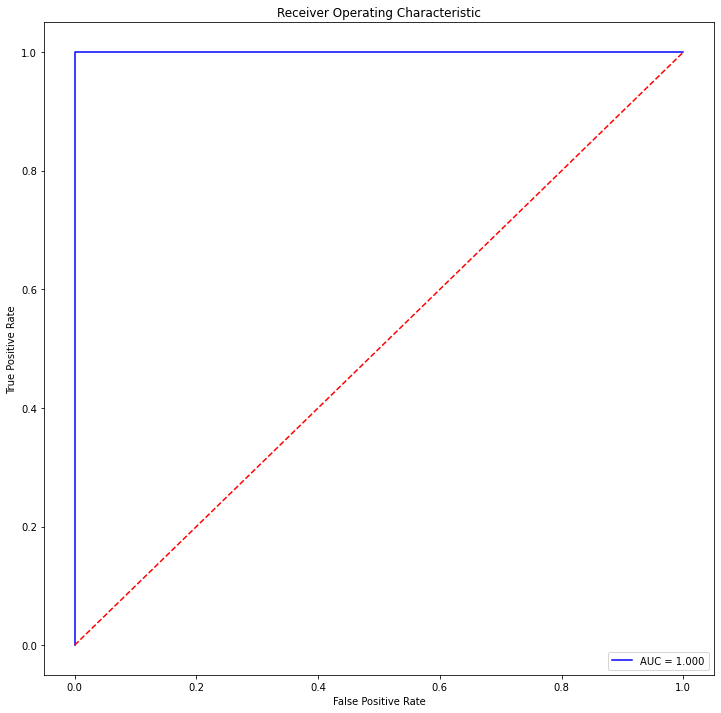

In [44]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(class_tr,proba_train_skl)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We obtain a perfect classification on the training set.

#### Confusion matrix on test set

In [45]:
data = {'y_Actual': class_te ,
        'y_Predicted': prediction_test_skl
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,400,11
1,12,452


In [46]:
erreur = sum(abs(class_te-prediction_test_skl))/N_test
print ('Classification error rate :', "{:.2%}".format(erreur))

Classification error rate : 2.63%


The error rate is divided by 3 compared to our logistic regression in exercise 2.

#### ROC curve

Text(0.5, 0, 'False Positive Rate')

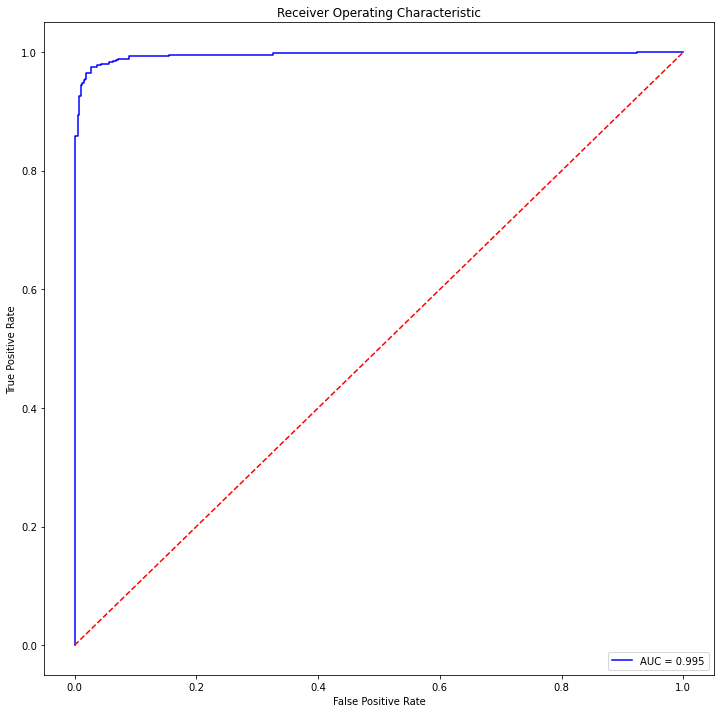

In [47]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(class_te,proba_test_skl)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Logistic regression with synthetic data

In [48]:
model = LogisticRegression(random_state=0).fit(x_train_1, t)
proba_train_skl_1 = model.predict_proba(x_train_1)[:,1]
proba_test_skl_1 = model.predict_proba(x_test_1)[:,1]
prediction_train_skl_1 = model.predict(x_train_1)
prediction_test_skl_1 = model.predict(x_test_1)

#### Confusion matrix on the training set

In [49]:
data = {'y_Actual': t ,
        'y_Predicted': prediction_train_skl_1
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,77,1
1,5,17


#### ROC curve

Text(0.5, 0, 'False Positive Rate')

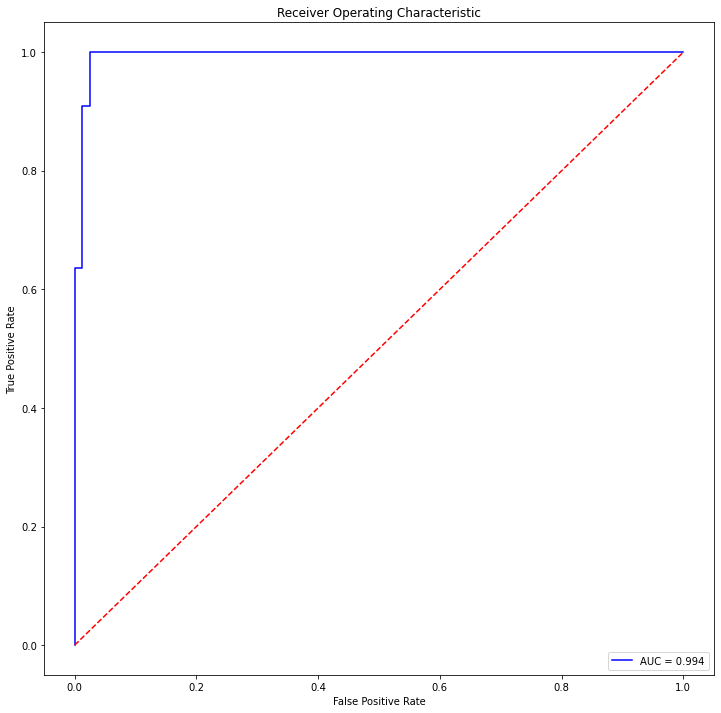

In [50]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(t,proba_train_skl_1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We have a 6% error rate, whereas we had a 3% error rate in exercise 1, but the ROC curve is very close to the ROC curve in exercise 1. Therefore, we could decrease the error rate by choosing another threshold.

#### Confusion matrix on test set

In [51]:
data = {'y_Actual': t_test ,
        'y_Predicted': prediction_test_skl_1
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,137,1
1,11,51


Text(0.5, 0, 'False Positive Rate')

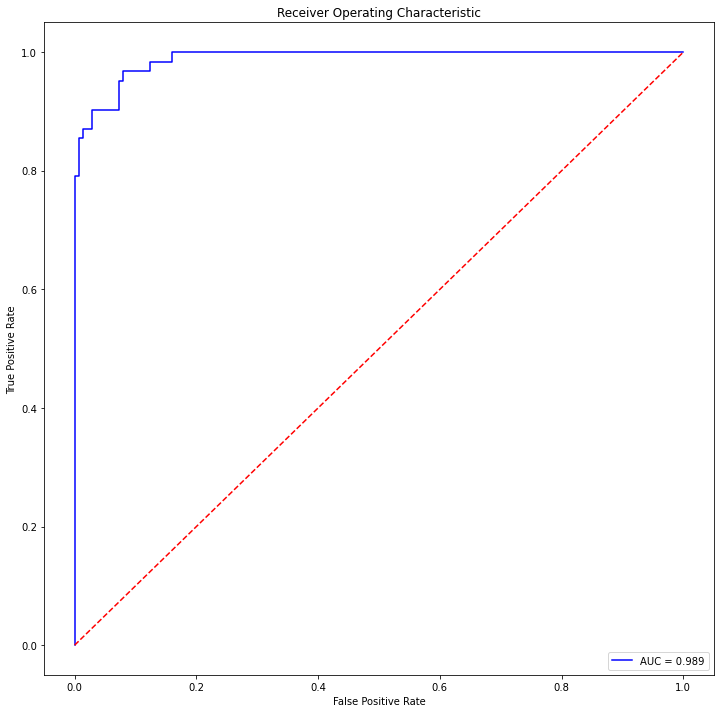

In [52]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(t_test,proba_test_skl_1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

We have the same error rate and the same AUC than in exercise 1.